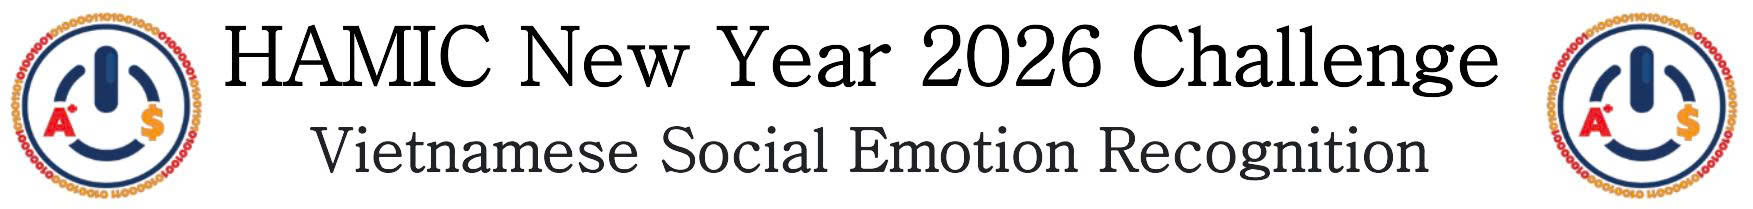

# HAMIC New Year 2026 Challenge - NLP Task

## Starter Notebook
**Sử dụng Mô hình Ngôn ngữ Tiền huấn luyện (PhoBERT) cho bài toán Nhận diện Cảm xúc**

## Giới thiệu

Chào mừng bạn đến với HAMIC New Year 2026 Challenge!

Trong notebook khởi động này, chúng tôi sẽ hướng dẫn bạn quy trình tinh chỉnh (fine-tuning) một mô hình ngôn ngữ tiền huấn luyện (`vinai/phobert-base`) trên bộ dữ liệu mẫu để xây dựng một mô hình phân loại cảm xúc. Notebook này được thiết kế để chạy trên môi trường Google Colab.

### Nội dung chính:

1.  **Cài đặt và Thư viện:** Thiết lập môi trường cần thiết.
2.  **Cấu hình:** Khai báo các tham số như tên mô hình, đường dẫn dữ liệu, siêu tham số.
3.  **Chuẩn bị Dữ liệu:** Tải xuống, đọc và tiền xử lý dữ liệu từ GitHub.
4.  **Dataset & DataLoader:** Tạo lớp Dataset của PyTorch để xử lý dữ liệu văn bản.
5.  **Kiến trúc Mô hình:** Định nghĩa mô hình dựa trên PhoBERT kết hợp với MLP.
6.  **Huấn luyện:** Vòng lặp huấn luyện mô hình.
7.  **Dự đoán & Nộp bài:** Tạo file kết quả `submission.csv` trên tập kiểm tra.

**Trước khi bắt đầu:**
*   Khuyên dùng **GPU** để tăng tốc độ huấn luyện. Trong Colab: Chọn `Runtime` -> `Change runtime type` -> `GPU`.

### Bước 1: Tải và Chuẩn bị Dữ liệu

Đầu tiên, chúng ta tải dữ liệu từ GitHub và chia tập huấn luyện (train) thành 2 phần: **Train** (để huấn luyện) và **Dev** (để đánh giá trong quá trình huấn luyện).

In [1]:
import os
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Cấu hình đường dẫn
TRAIN_URL = "https://raw.githubusercontent.com/HaianCao/HAMIC_New_Year_2026_Challenge/main/task-dataset/NLP_Task/train.csv"
TEST_URL = "https://raw.githubusercontent.com/HaianCao/HAMIC_New_Year_2026_Challenge/main/task-dataset/NLP_Task/test.csv"
TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"

In [2]:
# Hàm tải file
def download_file(url, filepath):
    if not os.path.exists(filepath):
        print(f"Đang tải {url}...")
        r = requests.get(url)
        with open(filepath, 'wb') as f:
            f.write(r.content)
        print("Đã tải xong.")
    else:
        print(f"{filepath} đã tồn tại.")

download_file(TRAIN_URL, TRAIN_PATH)
download_file(TEST_URL, TEST_PATH)

Đang tải https://raw.githubusercontent.com/HaianCao/HAMIC_New_Year_2026_Challenge/main/task-dataset/NLP_Task/train.csv...
Đã tải xong.
Đang tải https://raw.githubusercontent.com/HaianCao/HAMIC_New_Year_2026_Challenge/main/task-dataset/NLP_Task/test.csv...
Đã tải xong.


In [3]:
# Đọc dữ liệu
df_full = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

# Kiểm tra dữ liệu
print("Cột Train:", df_full.columns)
print("Cột Test:", df_test.columns)

Cột Train: Index(['ID', 'Sentence', 'Emotion'], dtype='object')
Cột Test: Index(['ID', 'Sentence'], dtype='object')


In [4]:
# Mã hóa nhãn (Label Encoding) từ cột Emotion
le = LabelEncoder()
df_full['label_id'] = le.fit_transform(df_full['Emotion'])
class_names = le.classes_
print(f"Các nhãn: {class_names}")

Các nhãn: ['anger' 'disgust' 'enjoyment' 'fear' 'other' 'sadness' 'surprise']


In [5]:
# Chia tập Train/Dev (90/10)
# Stratify giúp chia đều tỉ lệ các nhãn
train_df, dev_df = train_test_split(df_full, test_size=0.1, random_state=42, stratify=df_full['label_id'])

print(f"Train size: {len(train_df)}")
print(f"Dev size: {len(dev_df)}")

Train size: 5479
Dev size: 609


### Bước 2: Xây dựng Dataset & DataLoader

Chúng ta tạo một lớp `EmotionDataset` kế thừa từ `torch.utils.data.Dataset`. Lớp này sẽ:
1.  Nhận danh sách câu (Sentence) và nhãn (nếu có).
2.  Sử dụng Tokenizer của PhoBERT để chuyển văn bản thành `input_ids` và `attention_mask`.

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

MODEL_NAME = "vinai/phobert-base"
MAX_LEN = 128
BATCH_SIZE = 128

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class EmotionDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Lấy câu văn tại vị trí idx
        text = str(self.texts[idx])

        # Tokenize (Sử dụng cách gọi trực tiếp để tránh lỗi AttributeError)
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [7]:
# Tạo Dataset (Lưu ý: Dùng cột 'Sentence' cho văn bản)
train_dataset = EmotionDataset(train_df['Sentence'].values, train_df['label_id'].values, tokenizer, MAX_LEN)
dev_dataset = EmotionDataset(dev_df['Sentence'].values, dev_df['label_id'].values, tokenizer, MAX_LEN)

# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Bước 3: Xây dựng và Huấn luyện Mô hình

Chúng ta định nghĩa mô hình `PhoBertClassifier`:
-   **Backbone:** `vinai/phobert-base` (trích xuất đặc trưng văn bản).
-   **Header:** Một lớp Linear (MLP đơn giản) để phân loại cảm xúc.

In [8]:
import torch.nn as nn
from transformers import AutoModel
from tqdm.notebook import tqdm

class PhoBertClassifier(nn.Module):
    def __init__(self, n_classes):
        super(PhoBertClassifier, self).__init__()
        self.phobert = AutoModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(768, n_classes)  # 768 là hidden size của PhoBERT base

    def forward(self, input_ids, attention_mask):
        output = self.phobert(input_ids=input_ids, attention_mask=attention_mask)
        # Lấy vector CLS (token đầu tiên)
        cls_output = output.last_hidden_state[:, 0, :]
        return self.out(self.drop(cls_output))


In [9]:
# Khởi tạo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = PhoBertClassifier(len(class_names)).to(device)

# Optimizer & Loss
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Hàm huấn luyện 1 epoch
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    losses = []
    correct_predictions = 0

    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        losses.append(loss.item())
        correct_predictions += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

Using device: cuda


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: vinai/phobert-base
Key                             | Status     |  | 
--------------------------------+------------+--+-
lm_head.bias                    | UNEXPECTED |  | 
lm_head.dense.bias              | UNEXPECTED |  | 
lm_head.decoder.weight          | UNEXPECTED |  | 
lm_head.layer_norm.bias         | UNEXPECTED |  | 
lm_head.dense.weight            | UNEXPECTED |  | 
lm_head.layer_norm.weight       | UNEXPECTED |  | 
lm_head.decoder.bias            | UNEXPECTED |  | 
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [10]:
# Vòng lặp huấn luyện
EPOCHS = 3
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_acc, train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    print(f'Train loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')

Epoch 1/3


Training:   0%|          | 0/43 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Train loss: 1.5893, Accuracy: 0.3933
Epoch 2/3


Training:   0%|          | 0/43 [00:00<?, ?it/s]

Train loss: 1.4788, Accuracy: 0.4599
Epoch 3/3


Training:   0%|          | 0/43 [00:00<?, ?it/s]

Train loss: 1.3968, Accuracy: 0.4902


### Bước 4: Đánh giá Mô hình

Đánh giá hiệu suất trên tập Dev bằng Accuracy và F1-Score.

In [11]:
from sklearn.metrics import classification_report

def eval_model(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())

    return actual_labels, predictions

In [12]:
y_true, y_pred = eval_model(model, dev_loader, device)

# In báo cáo chi tiết
print(classification_report(y_true, y_pred, target_names=class_names))

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.43      0.16      0.23        38
     disgust       0.00      0.00      0.00        55
   enjoyment       0.54      0.71      0.61       193
        fear       0.00      0.00      0.00        12
       other       0.54      0.74      0.62       232
     sadness       0.68      0.29      0.41        52
    surprise       0.00      0.00      0.00        27

    accuracy                           0.54       609
   macro avg       0.31      0.27      0.27       609
weighted avg       0.46      0.54      0.48       609



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Bước 5: Dự đoán và Tạo File Nộp bài

Cuối cùng, chạy mô hình trên tập **Test** (không có nhãn), dự đoán và lưu kết quả vào file `submission.csv` theo định dạng yêu cầu.

In [13]:
# Tạo Dataset cho Test (Dùng cột 'Sentence', không có nhãn)
test_dataset = EmotionDataset(df_test['Sentence'].values, None, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Dự đoán
model.eval()
test_preds = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        test_preds.extend(preds.cpu().tolist())

# Chuyển về nhãn chữ (Emotion)
predicted_labels = le.inverse_transform(test_preds)

# Tạo DataFrame kết quả
# Chỉ lấy ID và Emotion
submission = pd.DataFrame({
    'ID': df_test['ID'],
    'Emotion': predicted_labels
})

# Lưu file submission.csv (không lưu index của pandas)
submission.to_csv("submission.csv", index=False)
print("Đã lưu submission.csv thành công!")
display(submission.head())

Predicting:   0%|          | 0/12 [00:00<?, ?it/s]

Đã lưu submission.csv thành công!


,ID,Emotion
0,5206,enjoyment
1,1704,enjoyment
2,5982,other
3,944,other
4,1762,other
